In [24]:
import numpy as np
import scipy as sp
import pandas as pd
import MySQLdb
import datetime, time
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from gurobipy import *
from matplotlib import gridspec
import itertools
import timeit
%matplotlib inline

matplotlib.rc('text', usetex=False)
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'legend.fontsize': 12})
current_palette = sns.color_palette()
current_color = current_palette[0]
sns.set(style="ticks", context="poster")
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'legend.fontsize': 12})

def flatten(mylist):
    return np.array(list(itertools.chain(*mylist)))


In [25]:
query = """SELECT
            EVENT_ID as event_id,
            DRIVER_ID as driver_id,
            EVSE_ID as evse_id,
            EVSE_ZIP as evse_zip,
            SESSION_START_DATETIME as time_start,
            SESSION_END_DATETIME as time_end,
            ENERGY as energy
            FROM sessiondata
            WHERE dataset_a=1
            AND driver_selected=1
            AND EVSE_ZIP=94043
            AND SESSION_START_DATE=SESSION_END_DATE;"""
google = pd.read_sql(query, con).sort('time_start')
google['time_start_dayofyear'] = google['time_start'].map(lambda x: x.dayofyear)
# google['time_start_dayofweek'] = google['time_start'].map(lambda x: x.dayofweek)
# sns.distplot(google['time_start_dayofyear'])\n",
# sns.distplot(google['time_start_dayofweek'])\n",
google = google[google['time_start_dayofyear'] == 301 ]
session_ids = '('+ ','.join([str(x) for x in list(google['event_id'])]) + ')'
google[0:3]

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:14: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,event_id,driver_id,evse_id,evse_zip,time_start,time_end,energy,time_start_dayofyear
68971,13287209,142375,8182,94043,2013-10-28 04:05:25,2013-10-28 06:42:28,8.289809,301
68972,13287827,5315,49003,94043,2013-10-28 05:20:37,2013-10-28 14:01:19,12.026091,301
68973,13287833,140017,8877,94043,2013-10-28 05:21:07,2013-10-28 09:23:14,5.961351,301


In [21]:
len(google)

85696

In [27]:
query = """SELECT
            EVENT_ID as event_id,
            AVERAGE_POWER as power,
            INTERVAL_start_datetime as time_start,
            INTERVAL_stop_datetime as time_end
            FROM mindata
            WHERE event_id in """ + session_ids +  """;"""
mindata = pd.read_sql(query, con).sort(columns = 'time_start')
def datetime_to_15min(x):
    return x.hour * 4 + int(x.minute / 15)
mindata['15min'] = mindata['time_start'].map(lambda x: datetime_to_15min(x))
print(len(mindata))
mindata[0:3]


10144


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,event_id,power,time_start,time_end,15min
0,13287209,3.0647,2013-10-28 04:05:25,2013-10-28 04:15:00,16
1,13287209,3.1655,2013-10-28 04:15:00,2013-10-28 04:30:00,17
2,13287209,3.1725,2013-10-28 04:30:00,2013-10-28 04:45:00,18


In [28]:
def optimizeForPeak(Slots, Power, Start, End_Charge, End_Session, K, ddelta, mode):
    ### Accepts slots and a corresponding positive power matrix for 2 cars: 
    ### Example slots=[[3,4,5],[4,5,6,7]] all slots start at 1!
    ########### power=[[P1,P2,P3],[P4,P5,P6,P7]]
    ### And the current start and end time slots for all cars:
    ########### start=[[3,3,3],[4,4,4,4], end=[[5,5,5],[7,7,7,7]]
    ## K is the total number of slots i.e. 24*60/15: 96 for a 15 minute resolution case

    ## mode stands for the specific optimization problem.
    #     it is a pair of binaries: (x,y)
    ## the first is for arrivals: if x=0, arrival times are fixed
    ## the second is for departures: if y=0, departure times are fixed
    
    m = Model('PeakOptimization')
    m.setParam('OutputFlag', True )
    m.setParam('MIPGap',0.05)
#     m.setParam('TimeLimit',5)
    
    ## CREATE OUR BINARY DECISION VARIABLE
    M = sum([len(slot) for slot in Slots])
    N = K
    X = {} #is an MxN binary decision variable where    
    for i in xrange(M):
        for j in xrange(N):
            X[i,j] = m.addVar(vtype=GRB.BINARY, name='X_%s_%s' % (i, j))
    m.update()
    
    ### Let's create a power vector corresponding to each row in X:
    power = flatten(Power)
    
    ### Let's create the right hand side of the constraint vector
    ### to control the start and end times.
    
    ## START TIME 
    start = flatten(Start) - ddelta * mode[0]
    start = np.clip(start, 0, max(start)) 
#     print('This is start:', start)
    for i in xrange(M):
        m.addConstr(quicksum(X[i,j]*(j+1) for j in xrange(N)) >= start[i], 'order_%s' % (i))

    
    ## END TIME FOR CHARGING
    end_charge = flatten(End_Charge) + ddelta * mode[1]
    end_session = flatten(End_Session)
    end_session = end_session[0:len(end_charge)]
#     end = np.minimum(end_charge, end_session) # this is to ensure ends are fixed by end of session.
    end = np.maximum(end_charge, end_session) # this is to ensure ends are fixed by end of session.
    end = np.clip(end, 0, K) # end values have to stay between 0 and K.
#     print('This is end:', end)
    for i in xrange(M):
        m.addConstr(quicksum(X[i,j]*(j+1) for j in xrange(N)) <= end[i], 'order_%s' % (i))
        
    # CONSTRAINT THAT ENSURES IT IS NOT PREEMPTIVE
    st, et = 0, 0
    for elem in Slots:
        et = et + len(elem)
        for i in xrange(st, et-1):
            m.addConstr(-1*quicksum(X[i,j]*(j+1) for j in xrange(N)) + 
                        quicksum(X[i+1,j]*(j+1) for j in xrange(N)),
                        GRB.EQUAL, 1,
                        'keep_order_% s' % (i))
        st=st+len(elem)

        
    ## ALL ROWS SHOULD ONLY HAVE ONE 1 THE REST SHOULD BE 0
    for i in xrange(M):
        m.addConstr(quicksum(X[i,j] for j in xrange(N)), GRB.EQUAL, 1,'single_%s' % (i)) 
   

    # WE ARE MINIMIZING Pmax which is a bound on maximum power
    Pmax = m.addVar(name='Pmax')
    m.update()
    for j in range(N):
        m.addConstr(quicksum(X[i,j]*power[i] for i in xrange(M)) <= Pmax,
                'bound_%s' % (j))

    # Solve the program.
    m.setObjective(Pmax, GRB.MINIMIZE)
    m.optimize()

    # Print solution
    sol=[]
    if m.status == GRB.status.OPTIMAL:
        solution = m.getAttr('x', X)
        for j in xrange(N):        
            sol.append(sum([int(solution[i,j])*power[i] for i in xrange(M)]))
        #corSlots=[Slots[int(s)] for s in sol] # THIS IS RELATIVE TO THE SLOTS 
        #ct=0
        #power=[p*0 for p in power]
        #for s in sol:
        #    power[int(s)]=positive_power[ct]
        #    ct=ct+1
        #return power,
        resultSlots=[]
        for i in xrange(M):
            resultSlots.append(sum(int(solution[i,j])*(j+1) for j in range(N)))
        ## Let's create a similar solution Slots
        reSlot=[]
        st, et = 0, 0
        for elem in Slots:
            et=et+len(elem)
            reSlot.append(resultSlots[st:et])
            st=st+len(elem)

#         print('Slots before optimization:', Slots)
#         print('Slots after optimization:', reSlot)
        print('Optimal Pmax:', m.objVal)
        return reSlot, m
    else:
        print('The solution is suboptimal')


In [5]:
Slots=[[1,2],[1,2,3]]
Power=[[10,20],[50,60,70]]
Start=[[1,1],[1,1,1]]
End=[[2,2],[3,3,3]]
End_Sess=[[2,2],[3,3,3]]
K=10
ddelta=1
reslot, m = optimizeForPeak(Slots,Power,Start,End,End_Sess,K,ddelta,(1,1))

('Optimal Pmax:', 79.99999999999989)


# Let's import some data to optimize a typical day.

In [29]:
# google[0:3]
mindata_clean = mindata[mindata['power']>0.01]
mindata[0:3]

,event_id,power,time_start,time_end,15min
0,13287209,3.0647,2013-10-28 04:05:25,2013-10-28 04:15:00,16
1,13287209,3.1655,2013-10-28 04:15:00,2013-10-28 04:30:00,17
2,13287209,3.1725,2013-10-28 04:30:00,2013-10-28 04:45:00,18


In [30]:
q = mindata_clean.groupby('event_id')['power'].apply(lambda x: x.tolist())
T = mindata.groupby('event_id')['15min'].apply(lambda x: x.tolist()) # this includes all mins
tau = mindata_clean.groupby('event_id')['15min'].apply(lambda x: x.tolist()) # this includes only the charging>0.01
start = tau.apply(lambda x: [min(x)]*len(x))
end_charge = tau.apply(lambda x: [max(x)]*len(x))
duration_charge = tau.apply(lambda x: len(x))
duration_session = T.apply(lambda x: len(x))
end_session = T.apply(lambda x: max(x))
df = pd.concat([q,tau,start,end_charge,end_session,duration_charge,duration_session], axis=1).reset_index()
df.columns = ['event_id','power','15min','start','end_charge','end_session','duration_charge','duration_session']
df['end_session'] = df.apply(lambda x: [x['end_session']]*x['duration_charge'], axis=1)
df

,event_id,power,15min,start,end_charge,end_session,duration_charge,duration_session
0,13287209,"[3.0647, 3.1655, 3.1725, 3.1814, 3.1726, 3.171...","[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]","[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]","[26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26]","[26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26]",11,11
1,13287827,"[3.5315, 3.6256, 3.6285, 3.6129, 3.6255, 3.612...","[21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 3...","[21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 2...","[34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 3...","[56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 5...",14,36
2,13287833,"[5.1397, 5.7835, 5.8299, 5.5426, 2.8385, 0.8071]","[21, 22, 23, 24, 25, 26]","[21, 21, 21, 21, 21, 21]","[26, 26, 26, 26, 26, 26]","[37, 37, 37, 37, 37, 37]",6,17
3,13287887,"[3.1354, 3.5608, 3.5445, 3.5485, 3.5564, 3.553...","[21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 3...","[21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 2...","[44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 4...","[44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 4...",22,24
4,13287989,"[5.3999, 5.749, 5.7306, 5.7097, 5.6819, 5.6627...","[22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 3...","[22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 2...","[41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 4...","[46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 4...",20,25
5,13288113,"[5.948, 6.1596, 6.191, 6.1702, 6.1704, 6.1806,...","[22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]","[22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22]","[32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32]","[32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32]",11,11
6,13288155,"[5.7762, 5.9983, 5.9868, 5.9783, 5.9848, 5.990...","[23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]","[23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23]","[34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34]","[35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35]",12,13
7,13288371,"[1.0638, 1.5509, 2.8314, 2.8277, 2.8316, 2.837...","[24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 3...","[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 2...","[43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 4...","[48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 4...",20,25
8,13288389,"[2.1566, 2.2567, 2.2697, 1.7303, 0.4934]","[24, 25, 26, 27, 28]","[24, 24, 24, 24, 24]","[28, 28, 28, 28, 28]","[29, 29, 29, 29, 29]",5,6
9,13288423,"[2.9384, 3.1096, 3.0816, 3.0967, 3.0766, 3.063...","[24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]","[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]","[35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35]","[57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57]",12,34


In [31]:
len(df)

439

In [7]:
power = list(df['power'])
slots = list(df['15min'])
start = list(df['start'])
end_charge = list(df['end_charge'])
end_session = list(df['end_session'])
K=95
D=2


In [9]:
reslots, m = optimizeForPeak(slots, power, start, end_charge, end_session, K, 2, (1,1))

def convert_to_full(slots):
    x = np.zeros((len(slots),95))
    for ids, slot in enumerate(slots):
        for s in slot:
            x[ids, s] = 1
    return np.transpose(x)   

def merge_for_plot(A, B):
    '''merging the two slots matrices A (original), B(optimized):
    1 means active slot only in actual,
    -1 means active slot only in optimized,
    2 means active in both,
    0 means inactive in both'''
    (x,y) = A.shape
    Z = np.zeros(A.shape)
    for i in range(x):
        for j in range(y):
            if A[i,j] == 0 and A[i,j] == B[i,j]:
                Z[i,j] = 0
            elif A[i,j] == 1 and A[i,j] == B[i,j]:
                Z[i,j] = 2
            elif A[i,j] == 1:
                Z[i,j] = 1
            else:
                Z[i,j] = -1
    return Z

reslots, m = optimizeForPeak(slots, power, start, end, K, 2)
X = convert_to_full(slots)
Xo = convert_to_full(reslots)
Z = merge_for_plot(X,Xo)

('Optimal Pmax:', 689.2725999999997)


NameError: name 'end' is not defined

In [12]:
results_x, results_y = {}, {}
ds = [0,1,2,3,4,5,6,7,8]
for fix_a in [0,1]:
    for fix_d in [0,1]:
        for dind, d in enumerate(ds):
            mode = (fix_a, fix_d, d)
            print mode
            reslots, m = optimizeForPeak(slots, power, start, end_charge, end_session, K, d, (fix_a,fix_d))
            # power curves
            p = flatten(power)
            real = flatten(slots)
            optim = flatten(reslots)
            powerdf = pd.DataFrame({'power':p, 'slots': real, 'optim':optim})
            Popt = powerdf.groupby('optim').agg('sum')['power']
            results_y[mode] = Popt
            results_x[mode] = np.array(Popt.index.astype(float))*15/60
actual_y = powerdf.groupby('slots').agg('sum')['power']
actual_x = np.array(actual_y.index.astype(float))*15/60 

(0, 0, 0)
('Optimal Pmax:', 939.0825999999997)
(0, 0, 1)
('Optimal Pmax:', 939.0825999999997)
(0, 0, 2)
('Optimal Pmax:', 939.0825999999997)
(0, 0, 3)
('Optimal Pmax:', 939.0825999999997)
(0, 0, 4)
('Optimal Pmax:', 939.0825999999997)
(0, 0, 5)
('Optimal Pmax:', 939.0825999999997)
(0, 0, 6)
('Optimal Pmax:', 939.0825999999997)
(0, 0, 7)
('Optimal Pmax:', 939.0825999999997)
(0, 0, 8)
('Optimal Pmax:', 939.0825999999997)
(0, 1, 0)
('Optimal Pmax:', 939.0825999999997)
(0, 1, 1)
('Optimal Pmax:', 908.2904999999965)
(0, 1, 2)
('Optimal Pmax:', 823.8310999999997)
(0, 1, 3)
('Optimal Pmax:', 768.2562)
(0, 1, 4)
('Optimal Pmax:', 717.6452999999999)
(0, 1, 5)
('Optimal Pmax:', 663.7296999999998)
(0, 1, 6)
('Optimal Pmax:', 637.791199999999)
(0, 1, 7)
('Optimal Pmax:', 614.1868)
(0, 1, 8)
('Optimal Pmax:', 593.3143)
(1, 0, 0)
('Optimal Pmax:', 939.0825999999997)
(1, 0, 1)
('Optimal Pmax:', 885.8279999999994)
(1, 0, 2)
('Optimal Pmax:', 802.7416000000003)
(1, 0, 3)
('Optimal Pmax:', 737.411799999

In [1]:
reslots, m = optimizeForPeak(slots, power, start, end_charge, end_session, K, 24, (1,1))

NameError: name 'optimizeForPeak' is not defined

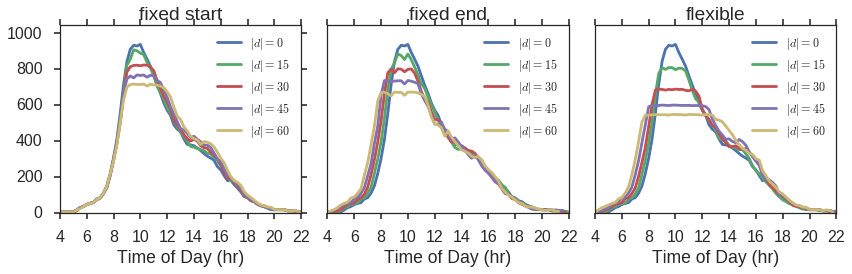

In [24]:
plt.figure(figsize=(12,4))
gs = gridspec.GridSpec(1,3)
titles = {(0,1): 'fixed start',
          (1,0): 'fixed end',
          (1,1): 'flexible'
         }
ds = [0,1,2,3,4,5,6,7,8]
for key, value in titles.iteritems():
    gridkey = key[0]*2 + key[1] - 1
    ax0 = plt.subplot(gs[0,gridkey])
    for d in ds[0:5]:
        delay = d*15
        plotkey = (key[0],key[1],d)
        ax0.plot(results_x[plotkey], results_y[plotkey], label='$|d|=' + str(delay) + "$")
#     ax0.plot(actual_x, actual_y, label='$d=0$')
    ax0.set_xlabel('Time of Day (hr)')
#     ax0.set_ylabel('Power (kW)')
    ax0.set_xlim([4,22])
    ax0.set_ylim([0,1050])
    ax0.set_title(titles[(key[0],key[1])])
    if gridkey>0:
        ax0.get_yaxis().set_ticks([])

    ax0.legend()

plt.tight_layout()
plt.savefig('/home/emre/Work/Mobility/figures/models_optim.pdf', transparent=True)

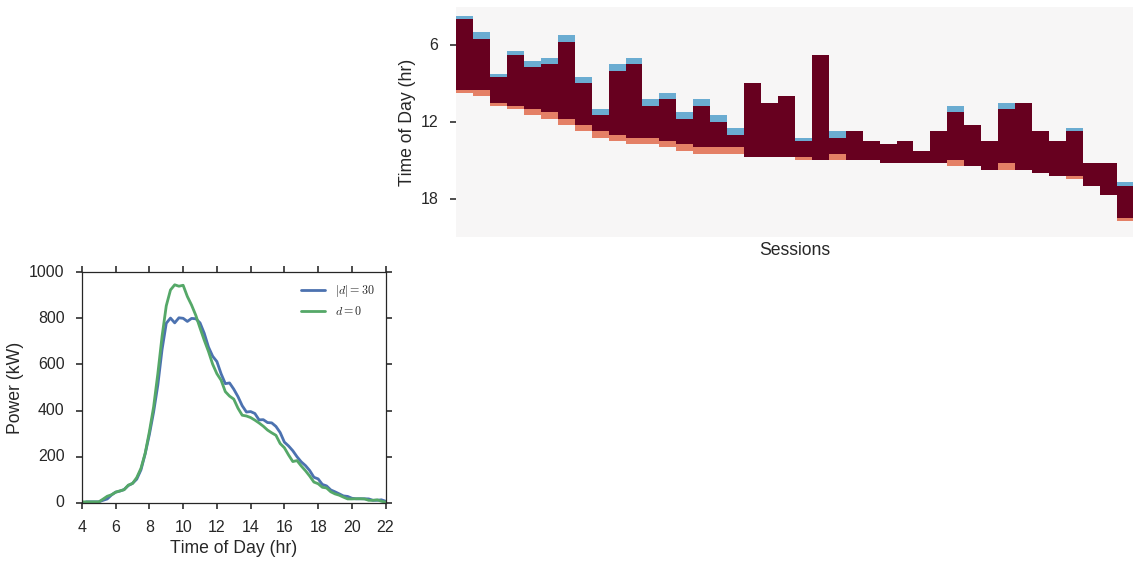

In [102]:
plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(2,3)

ax1 = plt.subplot(gs[0,1:])
Zplot = Z[:,range(0,400,10)]
sns.heatmap(Zplot, cmap="RdBu_r", cbar=False, ax=ax1, linewidths=0)
ax1.set_xticks([])
ax1.set_xlabel('Sessions')
ax1.set_ylabel('Time of Day (hr)')
ax1.set_yticks(range(0,96,24))
ax1.set_yticklabels(range(0,24,6))
ax1.set_ylim([12,84])
ax1.invert_xaxis()
ax1.invert_yaxis()

# current_palette = sns.palettes("RdBu_r")
current_palette = sns.color_palette("RdBu_r")


ax0 = plt.subplot(gs[1,0])
for d in [2,3,4,5,6]:
    delay = d*15
    ax0.plot(curves_x[d-2], curves_y[d-2], label='$|d|=' + str(delay) + "$")
    break
ax0.plot(curve_real_x, curve_real_y, label='$d=0$')
ax0.set_xlabel('Time of Day (hr)')
ax0.set_ylabel('Power (kW)')
ax0.set_xlim([4,22])
ax0.legend()


plt.tight_layout()
plt.savefig('/home/emre/Work/Mobility/figures/arrival_optim.pdf', transparent=True)

In [85]:
delays = []
starts = []
durations = []
for idx, slot in enumerate(slots):
    delays.append(slots[idx][0]-reslots[idx][0])
    starts.append(start[idx][0])
    durations.append(end[idx][0]-start[idx][0])
optimses = pd.DataFrame([delays,starts,durations]).transpose()
optimses.columns = ['delays','starts','durations']
optimses['delays'] = optimses['delays']*15
optimses['starts'] = optimses['starts']*15/60
optimses['durations'] = optimses['durations']*15/60

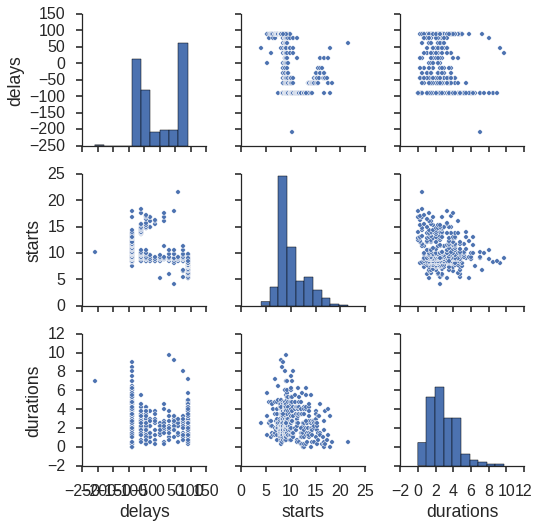

In [90]:
sns.pairplot(optimses)
# g = sns.PairGrid(optimses)
# g = g.map_upper(sns.regplot, x_bins=5)
# g = g.map_lower(sns.kdeplot, cmap="Blues_d")
# g = g.map_diag(sns.kdeplot, lw=3, legend=False)
# sns.distplot(delays)
# sns.regplot(x='delays', y='durations', data=optimses, x_bins=range(-91,91,15))

In [ ]:
# cost kismini silmisiz yanlislikla amk


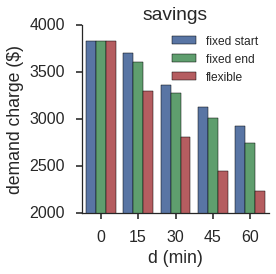

In [124]:
df = []
for key, val in cost.iteritems():
    for i, v in enumerate(val):
        df.append([titles[key], ds[i]*15, v])
df = pd.DataFrame(data=df, columns=['type','d','bill'])

plt.figure(figsize=(5,4))
sns.factorplot(x="d", y="bill", hue="type", data=df, kind="bar", legend=False)
plt.ylim([2000,4000])
sns.axlabel('d (min)','demand charge ($)')
plt.legend(loc='upper right')
plt.title('savings')
plt.tight_layout()
plt.savefig('/home/emre/Work/Mobility/figures/savings_optim.pdf', transparent=True)

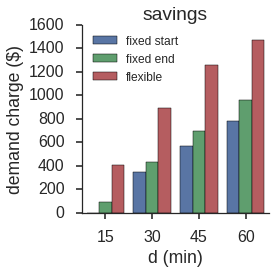

In [139]:
df['bill_saving'] = np.max(df['bill']) - df['bill']

plt.figure(figsize=(5,4))
df=df[df['d']!=0]
sns.factorplot(x="d", y="bill_saving", hue="type", data=df, kind="bar", legend=False)
# plt.xlim([10,80])
sns.axlabel('d (min)','demand charge ($)')
plt.legend(loc='upper left')
plt.title('savings')
plt.tight_layout()
plt.savefig('/home/emre/Work/Mobility/figures/savings_marginal_optim.pdf', transparent=True)

# Get arrival hour distribution

In [9]:
query = """SELECT
            EVENT_ID as event_id,
            DRIVER_ID as driver_id,
            EVSE_ID as evse_id,
            EVSE_ZIP as evse_zip,
            SESSION_START_DATETIME as time_start,
            SESSION_END_DATETIME as time_end,
            ENERGY as energy
            FROM sessiondata
            WHERE dataset_a=1
            AND driver_selected=1
            AND EVSE_ZIP=94043
            AND SESSION_START_DATE=SESSION_END_DATE;"""
google = pd.read_sql(query, con).sort('time_start')
google['time_start_dayofyear'] = google['time_start'].map(lambda x: x.dayofyear)
google[0:3]

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:14: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,event_id,driver_id,evse_id,evse_zip,time_start,time_end,energy,time_start_dayofyear
0,9800195,4697,4829,94043,2013-01-01 09:59:38,2013-01-01 11:06:47,4.129765,1
1,9801419,129195,53023,94043,2013-01-01 14:28:15,2013-01-01 19:38:37,18.477350,1
2,9804235,54013,69503,94043,2013-01-02 06:05:05,2013-01-02 15:35:45,0.848675,2


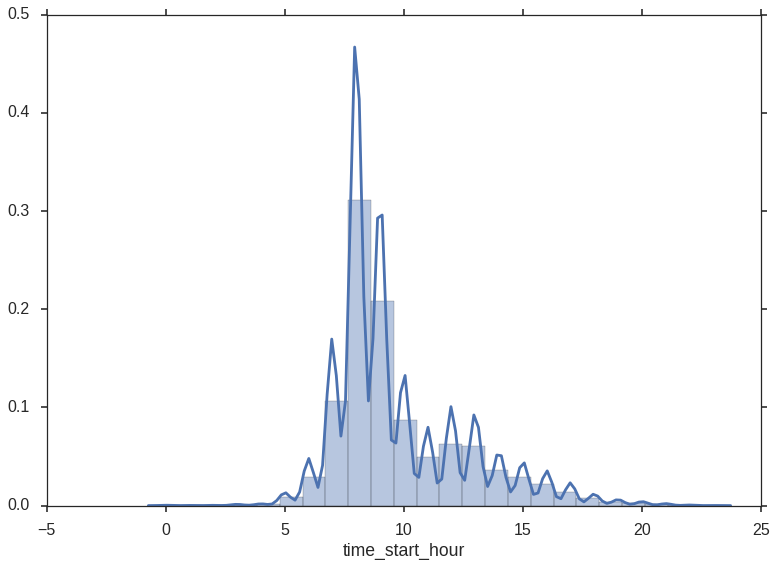

In [19]:
google['time_start_hour'] = google['time_start'].dt.hour
sns.distplot(google['time_start_hour'], bins=24, norm_hist=True)
import pickle

pickle.dump(list(google['time_start_hour']),open("/home/emre/Work/Mobility/google_arrival_times.pkl", 'wb'))
# n,b = np.histogram(google['time_start_hour'], bins=range(0,25))
